In [1]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
spark_session = SparkSession\
        .builder\
        .appName("Spark Regression")\
        .getOrCreate()

In [3]:
# Load and parse the data file, converting it to a DataFrame.
data = spark_session.read.format("libsvm").load("data/data_file.txt")
#data = spark_session.read.format("libsvm").load("data/classificationDataLibsvm.txt")

In [4]:
data.show()

+----------+--------------------+
|     label|            features|
+----------+--------------------+
|115.970001|(10,[0,1,2,3,4,5,...|
|    116.32|(10,[0,1,2,3,4,5,...|
|118.690002|(10,[0,1,2,3,4,5,...|
|119.029999|(10,[0,1,2,3,4,5,...|
|114.949997|(10,[0,1,2,3,4,5,...|
|110.440002|(10,[0,1,2,3,4,5,...|
|108.769997|(10,[0,1,2,3,4,5,...|
|108.860001|(10,[0,1,2,3,4,5,...|
|    115.32|(10,[0,1,2,3,4,5,...|
|111.199997|(10,[0,1,2,3,4,5,...|
|116.599998|(10,[0,1,2,3,4,5,...|
|115.050003|(10,[0,1,2,3,4,5,...|
|115.040001|(10,[0,1,2,3,4,5,...|
|    115.75|(10,[0,1,2,3,4,5,...|
|116.870003|(10,[0,1,2,3,4,5,...|
|117.510002|(10,[0,1,2,3,4,5,...|
|115.980003|(10,[0,1,2,3,4,5,...|
|119.019997|(10,[0,1,2,3,4,5,...|
|120.709999|(10,[0,1,2,3,4,5,...|
|121.190002|(10,[0,1,2,3,4,5,...|
+----------+--------------------+
only showing top 20 rows



In [280]:
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
#featureIndexer =\
#    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(data)

In [5]:
# Split the data into training and test sets (30% held out for testing)
#(trainingData, testData) = data.randomSplit([0.7, 0.3]) 
#(trainingData, testData) = l1NormData.randomSplit([0.7, 0.3])
(trainingData, testData) = data.randomSplit([0.7, 0.3])
print(trainingData.select("label").show(10))

+--------+
|   label|
+--------+
|0.115513|
|0.116629|
|0.117188|
|0.117188|
|0.117746|
|0.117746|
|0.118862|
|0.118862|
| 0.12221|
| 0.12221|
+--------+
only showing top 10 rows

None


In [6]:
# Train a RandomForest model.
#rf = RandomForestRegressor(featuresCol="indexedFeatures", numTrees=100, featureSubsetStrategy="auto",impurity='variance', maxDepth=20, maxBins=32)
rf = RandomForestRegressor(numTrees=15, featureSubsetStrategy="auto",
                                    impurity='variance', maxDepth=10, maxBins=64)

In [151]:
# Chain indexer and forest in a Pipeline
#pipeline = Pipeline(stages=[featureIndexer, rf])

In [7]:
# Train model.  This also runs the indexer.
#model = pipeline.fit(trainingData)
model = rf.fit(trainingData)

In [8]:
# Make predictions.
predictions = model.transform(testData)

In [9]:
# Select example rows to display.
predictions.select("prediction", "label", "features").show(5)

+-------------------+--------+--------------------+
|         prediction|   label|            features|
+-------------------+--------+--------------------+
| 0.1402073561270322|0.117188|(10,[0,1,2,3,4,5,...|
|0.14004418313817582|0.118304|(10,[0,1,2,3,4,5,...|
|0.14300684896515223|0.122768|(10,[0,1,2,3,4,5,...|
|0.14072389407575014|0.123326|(10,[0,1,2,3,4,5,...|
|0.14072389407575014|0.123326|(10,[0,1,2,3,4,5,...|
+-------------------+--------+--------------------+
only showing top 5 rows



In [10]:
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


Root Mean Squared Error (RMSE) on test data = 1.54799


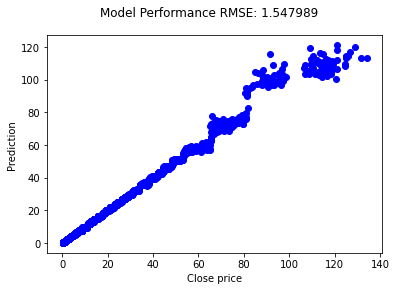

1.547988912787859


In [11]:
import matplotlib.pyplot as plt

rfPred = model.transform(data)

rfResult = rfPred.toPandas()

plt.plot(rfResult.label, rfResult.prediction, 'bo')
plt.xlabel('Close price')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

print(rmse)

In [12]:
from pyspark.ml.tuning import ParamGridBuilder
import numpy as np

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()

In [13]:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)

In [14]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

In [15]:
cvModel = crossval.fit(trainingData)

In [16]:
predictions = cvModel.transform(testData)

In [17]:
predictions.select("prediction", "label", "features").show(10)

+-------------------+--------+--------------------+
|         prediction|   label|            features|
+-------------------+--------+--------------------+
|0.34670789148658765|0.115513|(10,[0,1,2,3,4,5,...|
|0.34670789148658765|0.116629|(10,[0,1,2,3,4,5,...|
|0.34670789148658765|0.117188|(10,[0,1,2,3,4,5,...|
|0.34670789148658765|0.117746|(10,[0,1,2,3,4,5,...|
|0.34670789148658765|0.118304|(10,[0,1,2,3,4,5,...|
|0.34670789148658765| 0.12221|(10,[0,1,2,3,4,5,...|
|0.34670789148658765|0.122768|(10,[0,1,2,3,4,5,...|
|0.34670789148658765|0.124442|(10,[0,1,2,3,4,5,...|
|0.34670789148658765| 0.12779|(10,[0,1,2,3,4,5,...|
|0.34670789148658765|0.130022|(10,[0,1,2,3,4,5,...|
+-------------------+--------+--------------------+
only showing top 10 rows



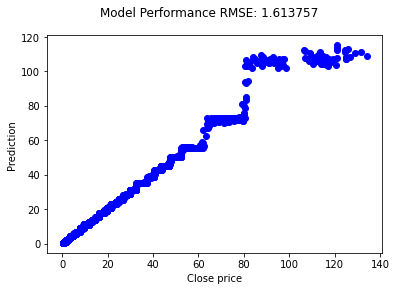

1.6137573762952826


In [18]:
import matplotlib.pyplot as plt

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(predictions)

rfPred = cvModel.transform(data)

rfResult = rfPred.toPandas()

plt.plot(rfResult.label, rfResult.prediction, 'bo')
plt.xlabel('Close price')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

print(rmse)

In [19]:
rmse

1.6137573762952826

Text(0.5, 1.0, 'Feature Importances')

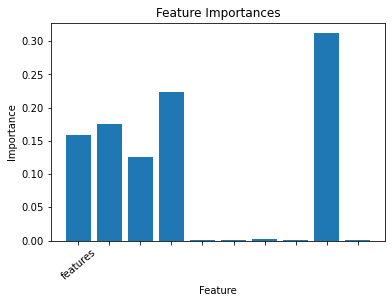

In [24]:
bestModel = cvModel.bestModel

importances = bestModel.featureImportances

x_values = list(range(len(importances)))

feature_list = ['symbol','date','open',high,low,close,adjClose,volume,unadjustedVolume,change,changePercent,vwap,label,'changeOverTime']

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')